<a href="https://colab.research.google.com/github/yehuda-yu/NLP-ESG-reporting/blob/main/DS_Practicum_Classify_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [ ]:
!pip install pdfplumber PyPDF2
! pip install transformers
import datetime
!pip install sentencepiece accelerate
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
import requests
from io import BytesIO
import os
import pdfplumber
import re
from urllib.parse import unquote
from tqdm import tqdm
import io
from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
palette = ['#ffbe0b',"#fb5607","#ff006e","#8338ec"]
sns.set_theme(style="white",font_scale = 1.2)
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Extract and Process PDF Files

This code extracts and processes PDF files. The following steps are performed:

1. read txt files with urls.
2. Create df with the url, company, and year for each pdf
3. For every URL, read the PDF and create list of senteces.

In [ ]:
def create_df_from_txt_file(txt_file_path):
    # Define a function to extract the year from the URL using regular expressions
    def extract_year(url):
        pattern = r'\b(19[0-9]{2}|20[0-9]{2})\b'
        matches = re.findall(pattern, url)
        return matches[0] if matches else None

    # Define a function to extract the company name from the URL
    def extract_company_name(url):
        components = url.split('/')
        company_name = components[components.index('pdfs') + 1]
        return unquote(company_name)

    # Read the URLs from the txt file
    with open(txt_file_path, 'r') as file:
        urls = file.read().splitlines()

    data = []
    for url in urls:
        # Extract the company name and year from each URL using the defined functions
        company_name = extract_company_name(url)
        year = extract_year(url)

        # Append the extracted data as a dictionary to the list
        data.append({'URL': url, 'Company Name': company_name, 'Year': year})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

In [ ]:
def pdf_to_text(url):
    try:
        response = requests.get(url)
        content = response.content
        file = io.BytesIO(content)
        reader = PdfReader(file)
        text = ''
        for i in range(len(reader.pages)):
            text += reader.pages[i].extract_text()
        return re.sub(r'\s+', ' ', text).strip()
    except Exception as e:
        return ''

def extract_sentences_from_pdf(url):
    sentences = []
    # Extract text using the pdf_to_text function
    text = pdf_to_text(url)
    # split to senteces by: . ! ? \n
    sentences.extend(re.split(r'[.!?]\s+|\n', text))
    return sentences

def process_df(df):
    # Use tqdm to create a progress bar for the URL processing
    tqdm.pandas(desc="Processing URLs")
    # Apply the extract_sentences_from_pdf function to each URL in the 'url' column
    df['sentences'] = df['URL'].progress_apply(extract_sentences_from_pdf)
    return df

In [ ]:
def clean_partial_processed_data(file_path: str) -> pd.DataFrame:

    """
    Processes a CSV file containing company data and category classifications.

    Args:
    - file_path (str): Path to the input CSV file.

    Returns:
    - pd.DataFrame: A DataFrame containing the processed data with columns: 'URL', 'Company Name', 'Year', and category classifications.
    """

    # Load the csv file into a DataFrame
    data = pd.read_csv(file_path)

    # Identify rows with unique URLs that start with 'https://'
    company_indicator_rows = data['URL'].str.startswith('https://', na=False)

    # Extract company data (URL, Company Name, and Year)
    company_data = data[company_indicator_rows][['URL', 'Company Name', 'Year']]

    # Extract category data from rows below the company rows
    category_data_rows = data.iloc[company_data.index[-1]+1:]
    category_data_cleaned = category_data_rows.dropna(subset=['category_1', 'category_2', 'category_3', 'category_4', 'category_5'])

    # Reset indices for proper alignment
    company_data = company_data.reset_index(drop=True)
    category_data_cleaned = category_data_cleaned.reset_index(drop=True)

    # Merge the two dataframes
    final_data = pd.concat([company_data, category_data_cleaned[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']]], axis=1)
    final_data.drop(['URL'],axis=1,inplace=True)
    final_data.dropna(inplace=True)
    final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']] = final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']].astype(int)
    return final_data


In [ ]:
txt_file_path = '/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/PDF files.txt'
df = create_df_from_txt_file(txt_file_path)

# Create df of the first 500 Companies
df_500 = df.loc[:499]
df_500

,URL,Company Name,Year
0,https://sust-reports-prod-v1.s3.us-east-2.amaz...,1ST SOURCE,2013
1,https://sust-reports-prod-v1.s3.us-east-2.amaz...,1ST SOURCE,2017
2,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2018
3,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2019
4,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2020
...,...,...,...
495,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2017
496,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2018
497,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2019
498,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2020


In [ ]:
# create senteces of each df in the first 500 companies
full_processed_df = process_df(df_500)
full_processed_df

Processing URLs: 100%|██████████| 500/500 [53:14<00:00,  6.39s/it]
<ipython-input-5-2f1dbad1174d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['URL'].progress_apply(extract_sentences_from_pdf)


,URL,Company Name,Year,sentences
0,https://sust-reports-prod-v1.s3.us-east-2.amaz...,1ST SOURCE,2013,[QUARTERLY COMPLIANCE REPORT ON CORPORATE GOVE...
1,https://sust-reports-prod-v1.s3.us-east-2.amaz...,1ST SOURCE,2017,[47 Annual Report 2017-18Business Responsibili...
2,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2018,"[2U, Inc, is a diverse collection of more than..."
3,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2019,"[Edtech with a human touch, 2U, INC, IS A DIVE..."
4,https://sust-reports-prod-v1.s3.us-east-2.amaz...,2U,2020,"[2020 ESG Report Culture, Equity, Education, H..."
...,...,...,...,...
495,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2017,[Ameriprise Financial Responsible Business Rep...
496,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2018,[Ameriprise Financial Responsible Business Rep...
497,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2019,[Ameriprise Financial Responsible Business Rep...
498,https://sust-reports-prod-v1.s3.us-east-2.amaz...,AMERIPRISE FINANCIAL,2020,"[Ameriprise Financial, Inc, Ameriprise Financi..."


In [ ]:
# Save to CSV
# full_processed_df.to_csv("/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/full-text-500-pdfs.csv", index=False)

##2.  Distributions

Present the distribution of years, companies, and senteces

In [ ]:
# load the df
df = pd.read_csv("/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/allPDFs-senteces.csv")

# Convert Year column to int
df['Year'] = df['Year'].astype(int)  # Convert 'Year' column to integer

# save columns
df = df[['Company Name', 'Year','sentences', 'category_1', 'category_2',
       'category_3', 'category_4', 'category_5']]

# split to senteces
def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]

# count number of senteces in each PDF
df['sentence_count'] = df['sentences'].apply(len)
df.head()

,Company Name,Year,sentences,category_1,category_2,category_3,category_4,category_5,sentence_count
0,1ST SOURCE,2013,[['QUARTERLY COMPLIANCE REPORT ON CORPORATE GO...,6,0,0,0,3,9
1,1ST SOURCE,2017,[['47 Annual Report 2017-18Business Responsibi...,24,1,26,9,89,188
2,2U,2018,"[['2U, Inc, is a diverse collection of more th...",15,4,19,2,27,66
3,2U,2019,"[['Edtech with a human touch, 2U, INC, IS A DI...",23,6,44,7,65,142
4,AMERICAN ELEC POWER COM,2021,"[[""['2021 Corporate Accountability Report BUIL...",150,81,680,336,548,1933


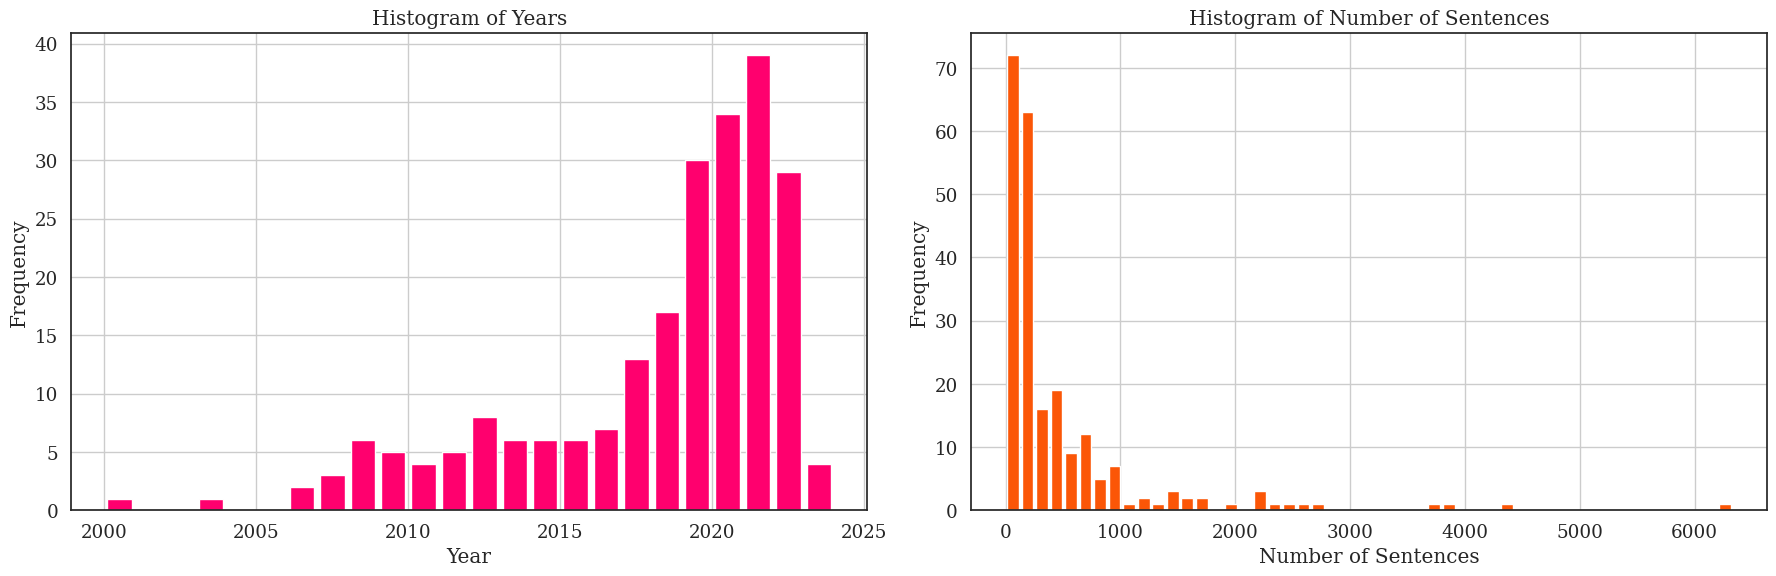

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot histogram of years
df['Year'].hist(ax=axes[0], bins=range(df['Year'].min(), df['Year'].max() + 2), rwidth=0.8,color = palette[2])
axes[0].set_title('Histogram of Years')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')

# Plot histogram of number of sentences
df['sentence_count'].hist(ax=axes[1], bins=50, rwidth=0.8,color = palette[1])
axes[1].set_title('Histogram of Number of Sentences')
axes[1].set_xlabel('Number of Sentences')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [ ]:
# Calculate statistics
statistics = {
    'Number of Sentences': {
        'Average': np.mean(df['sentence_count']),
        'Median': np.median(df['sentence_count']),
        'Standard Deviation': np.std(df['sentence_count']),
        'Max': int(np.max(df['sentence_count'])),
        'Min': int(np.min(df['sentence_count']))
    },
    'Year': {
        'Mode': df['Year'].mode().values[0],
        'Median': np.nan,
        'Standard Deviation': np.std(df['Year']),
       'Max': int(np.max(df['Year'])),
        'Min': int(np.min(df['Year']))
    }
}

# Create a DataFrame to display the statistics
statistics_df = pd.DataFrame(statistics)

# Display the table
statistics_df

,Number of Sentences,Year
Average,467.265487,NaN
Median,171.000000,NaN
Standard Deviation,764.872371,4.412931
Max,6327.000000,2023.000000
Min,1.000000,2000.000000
Mode,NaN,2021.000000


## 3. Apply the model

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/new3-full-text-500-pdfs.csv")
df['Year'] = df['Year'].astype(int)  # Convert 'Year' column to integer

def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]
df

,URL,Company Name,Year,sentences
0,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORPORATE OFFICE PROPERTIES,2020,[['Corporate Sustainability Report 2 Corporate...
1,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2020,[['1 2020 SUSTAINABILITY REPORT KEEP GROWING.I...
2,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2021,"[['IN IT FOR GOOD, 2021 SELECT ESG DISCLOSURES..."
3,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2022,[['NATURE AND SCOPE OF THE ASSURANCE/VERIFICAT...
4,https://sust-reports-prod-v1.s3.us-east-2.amaz...,COSTAMARE,2019,[['COSTAMARE ESG REPORT 2019Number of seafarer...
...,...,...,...,...
496,https://sust-reports-prod-v1.s3.us-east-2.amaz...,ELANCO ANIMAL HEALTH,2019,[['Food and Companionship Enriching Life 2019C...
497,https://sust-reports-prod-v1.s3.us-east-2.amaz...,ELANCO ANIMAL HEALTH,2020,"[['Environmental, Social & Governance (ESG) Su..."
498,https://sust-reports-prod-v1.s3.us-east-2.amaz...,ELANCO ANIMAL HEALTH,2021,"[['2021 Environmental, Social and Governance R..."
499,https://sust-reports-prod-v1.s3.us-east-2.amaz...,ELECTRONIC ARTS,2020,[['Impact Report 2020Introduction introduction...


Import model

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Create prompt and define df to store the model

In [ ]:
def detect_category(sentence):
    input_text = "Act as an expert ESG analyst.\n" \
                 "You will be provided a sentence related to a company's environmental, social, and governance (ESG) practices and performance. Your task is to classify each sentence into one of the following five categories:\n" \
                 "[1] Quantitative Evidence: The sentence contains specific numerical or percentage data demonstrating actions the company has already taken to improve its ESG measures. The sentence is primarily in past or present tense.\n" \
                 "[2] Action Evidence: The sentence contains concrete evidence, but no numbers/percentages, showing actions the company has already taken to improve ESG. The sentence is primarily in past or present tense.\n" \
                 "[3] Suggestive Evidence: The sentence suggests, but does not directly state, that the company has already taken actions to improve ESG. It does not contain concrete evidence. The sentence is primarily in past or present tense.\n" \
                 "[4] Intention: The sentence discusses the company's plans or intentions to take future ESG actions, but does not provide any evidence of current or past actions. The sentence is primarily in future tense.\n" \
                 "[5] Other: The sentence does not fit any of the above categories.\n"\
                 "For each sentence in the text file, return a number 1-5 indicating which category it belongs to.\n"\
                 f"Sentece: {sentence}"
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids
    outputs = model.generate(input_ids)
    output_text = tokenizer.decode(outputs[0])
    # Extract number from the output text using regex
    extracted_number = re.search(r'\d+', output_text)
    if extracted_number:
        return int(extracted_number.group())
    return None

processed_df = df.copy().reset_index()

# Initialize category columns in processed_df
for i in range(1, 6):
    processed_df[f'category_{i}'] = 0
processed_df

# Create df to store the results
processed_df = processed_df[['URL','Company Name','Year','sentences','category_1','category_2','category_3','category_4','category_5']]
processed_df.head()

,URL,Company Name,Year,sentences,category_1,category_2,category_3,category_4,category_5
0,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORPORATE OFFICE PROPERTIES,2020,[['Corporate Sustainability Report 2 Corporate...,0,0,0,0,0
1,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2020,[['1 2020 SUSTAINABILITY REPORT KEEP GROWING.I...,0,0,0,0,0
2,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2021,"[['IN IT FOR GOOD, 2021 SELECT ESG DISCLOSURES...",0,0,0,0,0
3,https://sust-reports-prod-v1.s3.us-east-2.amaz...,CORTEVA,2022,[['NATURE AND SCOPE OF THE ASSURANCE/VERIFICAT...,0,0,0,0,0
4,https://sust-reports-prod-v1.s3.us-east-2.amaz...,COSTAMARE,2019,[['COSTAMARE ESG REPORT 2019Number of seafarer...,0,0,0,0,0


In [ ]:
# Run the model on each sentence

for index, row in enumerate(processed_df.iterrows()):
    # Get the current timestamp
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Display message with timestamp for the PDF being processed
    print(f"\r[{current_time}] Processing PDF {index + 5}", end='', flush=True)

    _, row_data = row
    sentences_categories = []
    category_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    for sentence_num, sentence in enumerate(row_data['sentences']):
        # Display message with timestamp for the sentence being processed
        print(f"\r[{current_time}] Processing sentence {sentence_num + 1} in PDF {index + 5}", end='', flush=True)

        if len(sentence) < 5:
            continue

        category = detect_category(sentence)

        if category is None:
            print(f'\r[{current_time}] Skipped sentence due to error', end='', flush=True)
            continue

        sentences_categories.append(category)
        category_counts[category] += 1

    for i in range(1, 6):
        processed_df.at[index, f'category_{i}'] = category_counts[i]

    # Save the processed DataFrame to a CSV file every 5 iterations
    if (index + 1) % 3 == 0:
        partial_output_csv = f"/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/Yehuda-Model-dfs/partial_processed_data_{index + 451}.csv"
        processed_df.to_csv(partial_output_csv, index=False)
        print(f"\nSaved partially processed DataFrame to {partial_output_csv}")


# Print the processed DataFrame
print("\nProcessed DataFrame:")
print(processed_df)

[2023-08-11 14:23:19] Processing sentence 1 in PDF 5

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[2023-08-11 14:23:19] Processing sentence 278 in PDF 5

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


[2023-08-11 14:23:19] Processing sentence 630 in PDF 5

## 4. Results & Stataitics
Comparisons between different companies and different years

In [25]:
df = pd.read_csv("/content/drive/MyDrive/gdrive_folder/Courses/DS_Practicum/Final_Task/allPDFs.csv")
df = df[['Company Name', 'Year', 'category_1', 'category_2','category_3', 'category_4', 'category_5']]
df.head()

,Company Name,Year,category_1,category_2,category_3,category_4,category_5
0,1ST SOURCE,2013,6,0,0,0,3
1,1ST SOURCE,2017,24,1,26,9,89
2,2U,2018,15,4,19,2,27
3,2U,2019,23,6,44,7,65
4,AMERICAN ELEC POWER COM,2021,150,81,680,336,548


### Precentage of Category 5 (Other)

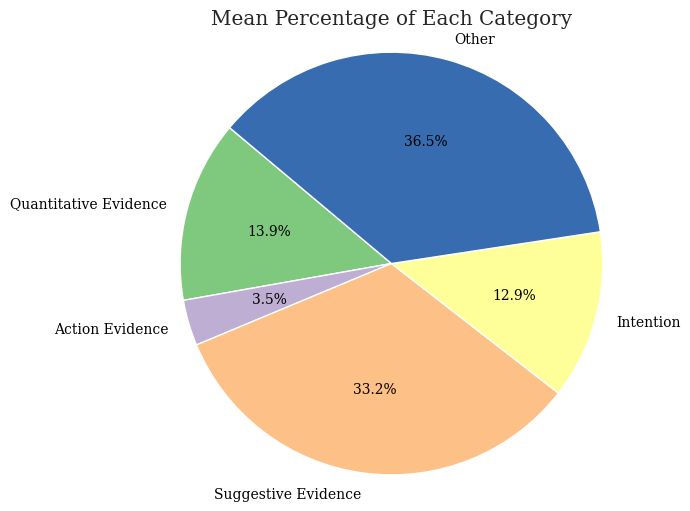

In [ ]:
categories = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Intention",
    "Other"
]

# Calculate the mean percentage for each category
mean_percentages = []
for category in categories:
    mean_percentage = df[category].mean()
    mean_percentages.append(mean_percentage)

# Create a pie plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    mean_percentages,
    labels=category_labels,
    autopct='%.1f%%',
    startangle=140,
    colors=plt.cm.Accent.colors,
    textprops=dict(color="black")
)

# Add category labels to the center of each wedge
for text, autotext in zip(texts, autotexts):
    text.set(size=10)
    autotext.set(size=10)

# Set title and aspect ratio
plt.title('Mean Percentage of Each Category')
plt.axis('equal')

# Show the plot
plt.show()

### Mean Precentage of each Category (1-4)

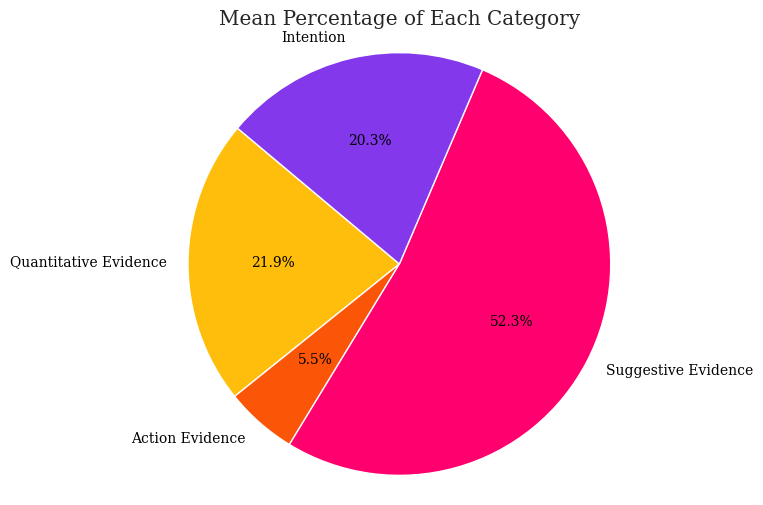

In [ ]:
categories = ['category_1', 'category_2', 'category_3', 'category_4']
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Intention",
]

# Calculate the mean percentage for each category
mean_percentages = []
for category in categories:
    mean_percentage = df[category].mean()
    mean_percentages.append(mean_percentage)

# Create a pie plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    mean_percentages,
    labels=category_labels,
    autopct='%.1f%%',
    startangle=140,
    colors=palette,
    textprops=dict(color="black")
)

# Add category labels to the center of each wedge
for text, autotext in zip(texts, autotexts):
    text.set(size=10)
    autotext.set(size=10)

# Set title and aspect ratio
plt.title('Mean Percentage of Each Category')
plt.axis('equal')

# Show the plot
plt.show()

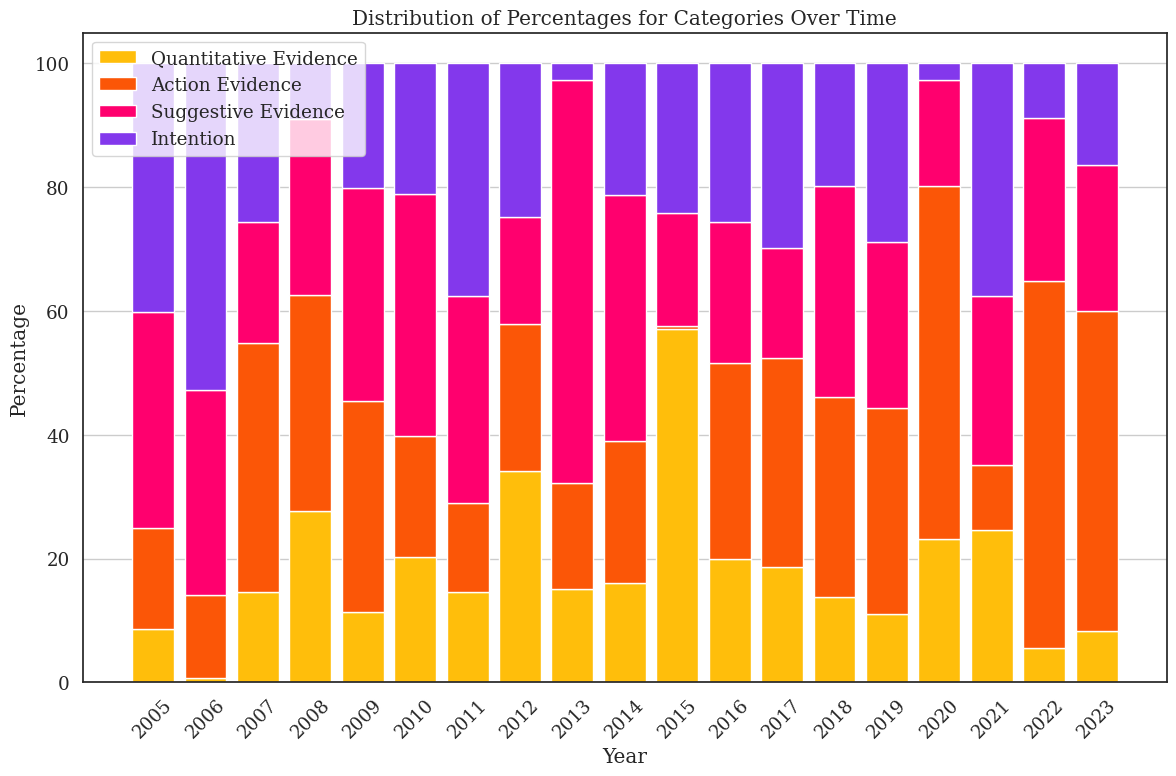

In [ ]:
# Assuming your DataFrame is named 'df'
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Intention"
]

years = np.arange(2005, 2024)

# Generate random data for demonstration (replace this with your data)
data = np.random.randint(0, 101, size=(len(category_labels), len(years)))

# Calculate the sum of percentages for each year
yearly_totals = np.sum(data, axis=0)

# Normalize the data to get percentages
normalized_data = data / yearly_totals * 100

fig, ax = plt.subplots(figsize=(12, 8))

# Create a stacked bar plot for each category
bottom = np.zeros(len(years))
for idx, category_label in enumerate(category_labels):
    bars = ax.bar(years, normalized_data[idx], label=category_label, bottom=bottom, color=palette[idx])
    bottom += normalized_data[idx]

ax.set_title("Distribution of Percentages for Categories Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.legend()
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax.grid(axis="y")

plt.tight_layout()
plt.show()

### Compare Companies percentages of Categories 1+2 Over Years

/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


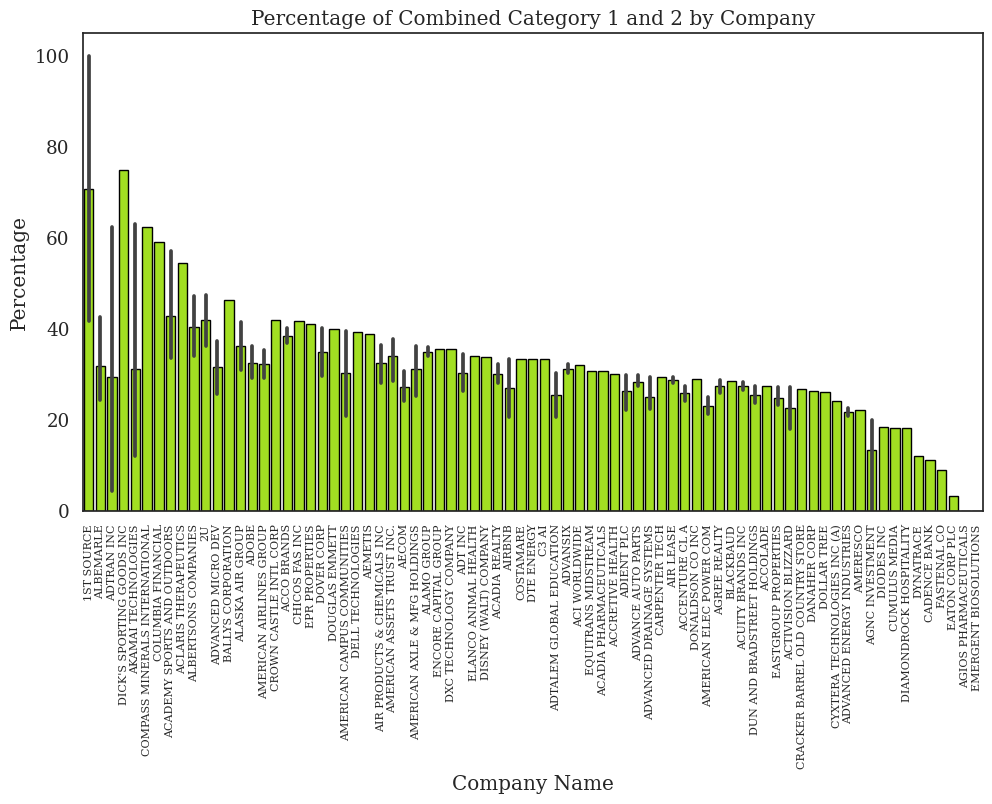

ANOVA P-value for Combined Category 1 and 2: nan


In [20]:
# Step 1: Convert numbers in each category to percentages.
category_columns = ['category_1', 'category_2', 'category_3', 'category_4']
df[category_columns] = df[category_columns].div(df[category_columns].sum(axis=1), axis=0) * 100

# Calculate the percentage for combined categories 1 and 2
df['category_1_2'] = df['category_1'] + df['category_2']

# Step 2: Perform ANOVA test between the companies for combined Category 1 and 2 across all years
company_data = []
for company in df['Company Name'].unique():
    company_data.append(df[df['Company Name'] == company]['category_1_2'].values)

p_value = stats.f_oneway(*company_data).pvalue

# Sort DataFrame by combined Category 1 and 2 percentage
sorted_df = df.sort_values(by='category_1_2', ascending=False)

# Step 3: Generate a bar plot to display the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Company Name', y='category_1_2', data=sorted_df, color='#adff02', edgecolor='black')
plt.xlabel('Company Name')
plt.ylabel('Percentage')
plt.title('Percentage of Combined Category 1 and 2 by Company')
plt.tight_layout()
plt.xticks(rotation=90,fontsize=8)
plt.show()

# Print the ANOVA test results
print("ANOVA P-value for Combined Category 1 and 2:", p_value)

Top and Bottom Companies:


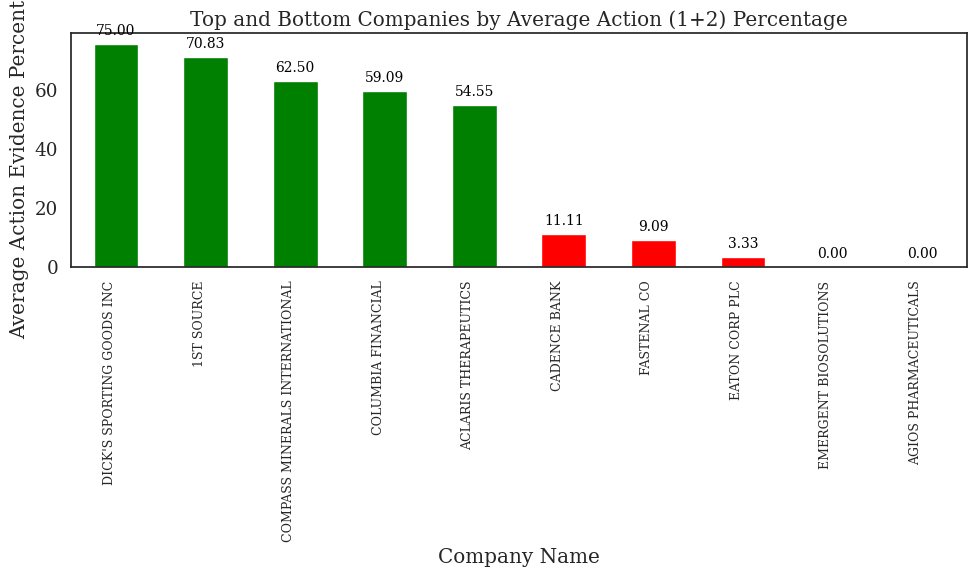

In [ ]:
# Calculate the average 'Action Evidence' (category_1+category_2) percentage for each company
df['Avg_Action_Evidence'] = (df['category_1'] + df['category_2']) / (df['category_1'] + df['category_2'] + df['category_3'] + df['category_4']) * 100

# Calculate the mean for each company and sort the DataFrame
sorted_df = df.groupby('Company Name')['Avg_Action_Evidence'].mean().sort_values(ascending=False)

# Select the top 5 and bottom 5 companies
top_companies = sorted_df.head(5)
bottom_companies = sorted_df.tail(5)

# Display results in a table
results_table = pd.concat([top_companies, bottom_companies])
print("Top and Bottom Companies:")
# print(results_table)

# Define colors based on values
colors = ['green' if company in top_companies.index else 'red' for company in results_table.index]

# Display results in a bar graph with values and colored bars
plt.figure(figsize=(10, 6))
ax = results_table.plot(kind='bar', color=colors)
plt.title('Top and Bottom Companies by Average Action (1+2) Percentage')
plt.xlabel('Company Name')
plt.ylabel('Average Action Evidence Percentage')
plt.xticks(rotation=90, ha='right',fontsize=9)

# Add values above each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Evidence/Intention ratio

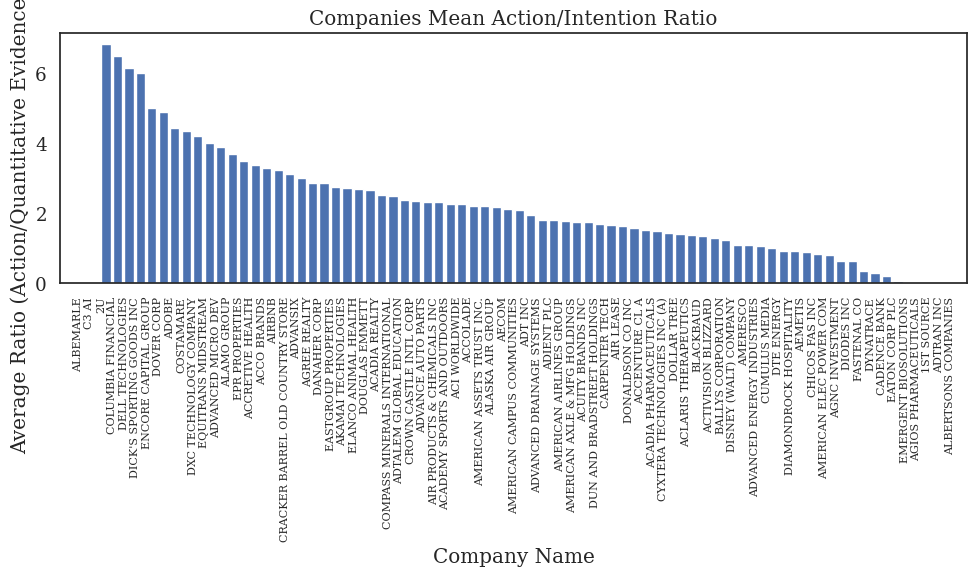

In [ ]:
# Calculate the ratio of action/quantitative evidence sentences to intention sentences
df["Ratio"] = (df["category_1"] + df["category_2"]) / df["category_4"]

# Calculate the average ratio for each company
average_ratios = df.groupby("Company Name")["Ratio"].mean().reset_index()

# Sort the  DataFrame by the average ratio in descending order
sorted_average_ratios = average_ratios.sort_values(by="Ratio", ascending=False)

# Create a bar chart for filtered and sorted average ratios
plt.figure(figsize=(10, 6))
plt.bar(sorted_average_ratios["Company Name"], sorted_average_ratios["Ratio"],)
plt.xlabel("Company Name")
plt.ylabel("Average Ratio (Action/Quantitative Evidence to Intention)")
plt.title("Companies Mean Action/Intention Ratio")

# Adjust x-axis labels for better visibility
plt.xticks(rotation=90, ha="right", fontsize=8)

plt.tight_layout()
plt.show()

<ipython-input-15-a2cab8799b70>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_average_ratios = average_ratios[(sorted_average_ratios["Ratio"] > 0) & (sorted_average_ratios["Ratio"] < 1)]


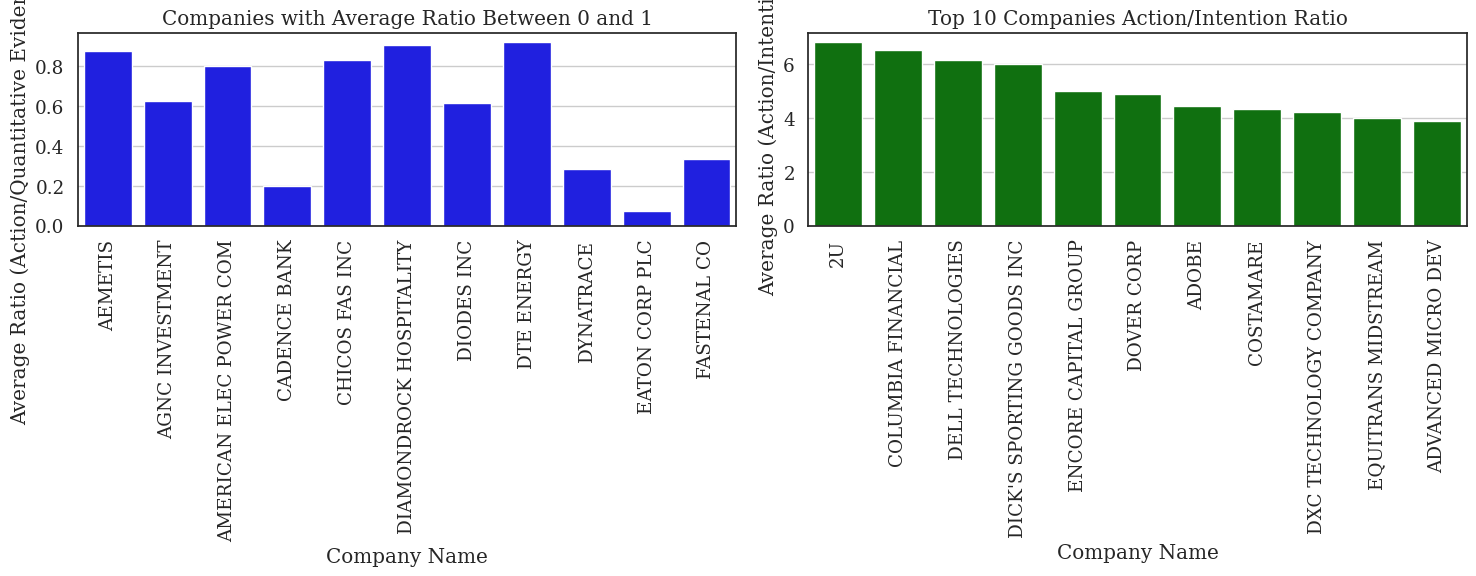

In [ ]:
# Filter companies with an average ratio greater than 0 and less than 1
filtered_average_ratios = average_ratios[(sorted_average_ratios["Ratio"] > 0) & (sorted_average_ratios["Ratio"] < 1)]

# Get the top 10 companies
top_10 = sorted_average_ratios.reset_index().loc[2:12]

# Create a figure with two subplots in 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# First subplot for filtered and sorted average ratios
sns.barplot(x='Company Name', y='Ratio', data=filtered_average_ratios, color='blue', ax=axes[0])
axes[0].set_xlabel('Company Name')
axes[0].set_ylabel('Average Ratio (Action/Quantitative Evidence to Intention)')
axes[0].set_title('Companies with Average Ratio Between 0 and 1')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

# Second subplot for top 10 companies
sns.barplot(x='Company Name', y='Ratio', data=top_10, color='green', ax=axes[1])
axes[1].set_xlabel('Company Name')
axes[1].set_ylabel('Average Ratio (Action/Intention)')
axes[1].set_title('Top 10 Companies Action/Intention Ratio')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()